# Collaborative filtering recommendation algorithm

This recommendation algorithm uses collaborative filtering approach to find:

1. Artists that are similar to other artists
2. If a user has listened to a set of artists, which other artists they would likely enjoy listening to. 


### Data

1. Artists - 17.5K records
2. Users - 1892 records
3. Interactions - how many times a user has listened to an Artist - 92K records


### Approach
* Uses deep learning to fill out the empty spaces in the sparse Interaction matrix.
* Uses 32 Latent features to create the .... TODO

#### Credits

* TODO: Alchemy


In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
artist_dir = "data/lastfm_artist_list.csv"
names = ['artist_id', 'artist_name']
item_data = pd.read_csv((artist_dir))
item_data.head()

,artist_id,artist_name
0,1,__Max__
1,2,_Algol_
2,3,-123 Min.
3,4,-Oz-
4,5,-T De Sangre


In [4]:
data_dir = "data/lastfm_user_scrobbles.csv"
names = ['user_id', 'artist_id', 'scrobbles']
rating_data = pd.read_csv(data_dir)

In [5]:
rating_data.head()

,user_id,artist_id,scrobbles
0,1,4562,13883
1,1,10191,11690
2,1,494,11351
3,1,6673,10300
4,1,8402,8983


In [6]:
data = rating_data.merge(item_data)
data.head()

,user_id,artist_id,scrobbles,artist_name
0,1,4562,13883,Duran Duran
1,3,4562,228,Duran Duran
2,25,4562,85,Duran Duran
3,26,4562,10,Duran Duran
4,60,4562,528,Duran Duran


In [7]:
class RatingDataset:
    def __init__(self, users, items, ratings):
        self.users = users
        self.items = items
        self.ratings = ratings
    # len(rating_dataset)
    def __len__(self):
        return len(self.users)
    # rating_dataset[1] 
    def __getitem__(self, item):

        users = self.users[item]
        items = self.items[item]
        ratings = self.ratings[item]
        
        return {
            "users": torch.tensor(users, dtype=torch.long),
            "items": torch.tensor(items, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.long),
        }

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_factors, num_users, num_items):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        
        self.user_embed = nn.Embedding(num_users, num_factors)
        self.item_embed = nn.Embedding(num_items, num_factors)
        # user, item embedding concat
        self.out = nn.Linear(num_factors*2, 1)

    
    def forward(self, user_id, item_id, ratings=None):
        user_embeds = self.user_embed(user_id)
        item_embeds = self.item_embed(item_id)
        output = torch.cat([user_embeds, item_embeds], dim=1)
        output = self.out(output)
        
        return output
    

In [40]:
values, counts = np.unique(data['scrobbles'], return_counts=True)

In [42]:
once_values = []
for idx, n in enumerate(values):
    if counts[idx] == 1:
        once_values.append(values[idx])
       

In [ ]:
# encode the user and artist id to start from 0 so we don't run into index out of bound with Embedding
lbl_user = preprocessing.LabelEncoder()
lbl_item = preprocessing.LabelEncoder()
data.user_id = lbl_user.fit_transform(data.user_id.values)
data.artist_id = lbl_item.fit_transform(data.artist_id.values)


data_train, data_valid = model_selection.train_test_split(
    data, test_size=0.1, random_state=42, stratify=data.scrobbles
)


In [57]:
train_dataset = RatingDataset(
    users=data_train.user_id.values,
    items=data_train.artist_id.values,
    ratings=data_train.scrobbles.values
)

valid_dataset = RatingDataset(
    users=data_valid.user_id.values,
    items=data_valid.artist_id.values,
    ratings=data_valid.scrobbles.values
)


In [58]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2)

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2) 

dataiter = iter(train_loader)
dataloader_data = dataiter.next()

print(dataloader_data)

{'users': tensor([ 931, 1457, 1608,  254]), 'items': tensor([14593,  1763, 16092, 10680]), 'ratings': tensor([532,  72, 379, 741])}


In [59]:
model = NeuralNetwork(num_factors=32,
    num_users=len(lbl_user.classes_),
    num_items=len(lbl_item.classes_),
).to(device)

optimizer = torch.optim.Adam(model.parameters())  
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

loss_func = nn.MSELoss()

In [60]:
print(len(lbl_user.classes_))
print(len(lbl_item.classes_))
print(data.artist_id.max())
print(len(train_dataset))

1892
17493
17492
83512


In [61]:
print(dataloader_data['users'])

print(dataloader_data['users'].size())
print(dataloader_data['items'] )
print(dataloader_data['items'].size())

user_embed = nn.Embedding(len(lbl_user.classes_), 32)
movie_embed = nn.Embedding(len(lbl_item.classes_), 32)
out = nn.Linear(64, 1).to(device)

tensor([ 931, 1457, 1608,  254])
torch.Size([4])
tensor([14593,  1763, 16092, 10680])
torch.Size([4])


In [62]:
with torch.no_grad():
    model_output = model(dataloader_data['users'].to(device), 
                   dataloader_data["items"].to(device))

    print(f"model_output: {model_output}, size: {model_output.size()}")

model_output: tensor([[-0.8806],
        [-0.0350],
        [-0.1755],
        [ 0.6993]], device='cuda:0'), size: torch.Size([4, 1])


In [63]:
rating = dataloader_data["ratings"]
print(rating)
print(rating.view(4, -1))
print(model_output)

print(rating.sum())

print(model_output.sum() - rating.sum())

tensor([532,  72, 379, 741])
tensor([[532],
        [ 72],
        [379],
        [741]])
tensor([[-0.8806],
        [-0.0350],
        [-0.1755],
        [ 0.6993]], device='cuda:0')
tensor(1724)
tensor(-1724.3920, device='cuda:0')


In [64]:
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = [] 

model.train() 
for epoch_i in range(epochs):
    for i, train_data in enumerate(train_loader):
        output = model(train_data["users"].to(device), 
                       train_data["items"].to(device)
                      ) 
        
        # .view(4, -1) is to reshape the rating to match the shape of model output which is 4x1
        rating = train_data["ratings"].view(4, -1).to(torch.float32).to(device)

        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt = step_cnt + len(train_data["users"])
        

        if(step_cnt % plot_steps == 0):
            avg_loss = total_loss/(len(train_data["users"]) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0 # reset total_loss

epoch 0 loss at step: 5000 is 698215.7646901245
epoch 0 loss at step: 10000 is 306508.57476223755
epoch 0 loss at step: 15000 is 824627.2924799743
epoch 0 loss at step: 20000 is 551367.1162804321
epoch 0 loss at step: 25000 is 1105972.6467098144
epoch 0 loss at step: 30000 is 858266.6519968017
epoch 0 loss at step: 35000 is 1407638.431593286
epoch 0 loss at step: 40000 is 1783541.422690149
epoch 0 loss at step: 45000 is 1282910.7615878778
epoch 0 loss at step: 50000 is 584571.1363427475
epoch 0 loss at step: 55000 is 591060.182465216
epoch 0 loss at step: 60000 is 475326.18323396606
epoch 0 loss at step: 65000 is 411793.13521000824
epoch 0 loss at step: 70000 is 1614847.394148976
epoch 0 loss at step: 75000 is 284811.57304502564
epoch 0 loss at step: 80000 is 1019572.011293927


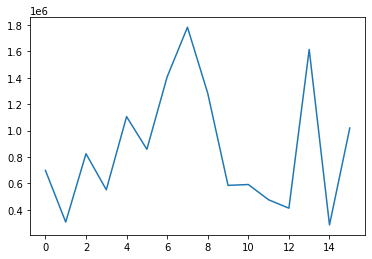

In [65]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

In [66]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval()

with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        model_output = model(batched_data['users'].to(device), 
                       batched_data["items"].to(device))
        
        model_output_list.append(model_output.sum().item() / len(batched_data['users']) )

        target_rating = batched_data["ratings"]
        
        target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))

        print(f"model_output: {model_output}, target_rating: {target_rating}")


# squared If True returns MSE value, if False returns RMSE value.
rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f"rms: {rms}")

model_output: tensor([[166.2316],
        [100.0640],
        [126.6124],
        [142.3064]], device='cuda:0'), target_rating: tensor([128, 130, 371, 152])
model_output: tensor([[100.2926],
        [127.3160],
        [ 88.8926],
        [ 70.8903]], device='cuda:0'), target_rating: tensor([ 59, 303, 293, 230])
model_output: tensor([[ 85.4131],
        [126.9044],
        [ 74.4746],
        [-21.0117]], device='cuda:0'), target_rating: tensor([6370,  632,   24,    2])
model_output: tensor([[134.9026],
        [160.6979],
        [120.6218],
        [139.3509]], device='cuda:0'), target_rating: tensor([ 468,  414, 1638,   79])
model_output: tensor([[ 83.6762],
        [102.9450],
        [100.2711],
        [ 80.5299]], device='cuda:0'), target_rating: tensor([ 24, 137, 315,  56])
model_output: tensor([[ 57.6294],
        [155.9801],
        [ 56.0478],
        [ 58.8641]], device='cuda:0'), target_rating: tensor([896, 473,  19, 129])
model_output: tensor([[98.5935],
        [92.5455]

In [67]:
class RMSE(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def update(self,yhat,y):
        self.loss = torch.Tensor.sqrt(self.mse(yhat,y))
        #self.value = self.loss.item()
        return self.loss
    
    def get(self):
        return self.loss.item()

In [68]:
loss_fn = RMSE()

In [69]:
def test(validation_loader, model, loss_fn):
    # evaluate model with test data at the end of each epoch by monitoring changes in accuracy and loss
    size = len(validation_loader.dataset) # 10k
    num_batches = len(validation_loader) # 157 = len(test_test_iter)
    # sets the model in eval mode

    test_loss, correct  = 0, 0
    model.eval()
    with torch.no_grad():
        for i, batched_data in enumerate(validation_loader): 
            model_output = model(batched_data['users'].to(device), 
                        batched_data["items"].to(device))
            
            #model_output_list.append(model_output.sum().item() / len(batched_data['users']) )

            target_rating = batched_data["ratings"].to(device)
            
            target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))
            
            test_loss += loss_fn.update(model_output, target_rating).item()
            
            for model_output, target_rating in zip(model_output, target_rating): 
                x = model_output.unsqueeze_(1).type(torch.float).sum().item()
                
                correct += (round(x) == target_rating.item())   
               
    test_loss /= num_batches # average loss
    correct /= size 
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [70]:
test_rmse = test(validation_loader, model, loss_fn)

/home/evgeniya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Accuracy: 0.3%, Avg loss: 1115.127618 

